# Lea's AI experiment

I'm a DOS enthusiast and created a pixel rasterfont editor, called [pixelfedit](https://github.com/learosema/pixelfedit). You can edit raster fonts in the sizes 8x8, 8x14 or 8x16. These were commonly used in the EGA and VGA text modes. VGA graphics cards had the possibility to replace the character symbols with your own definitions, so I made this editor. It was originally a Pascal program written in 1996, now ported to the web.

As it is sometimes a bit tedious to draw all the characters, especially the ones you don't need to often, I want to add GenAI to help me with the tedious work.

So, A thing I want to try is to create a generative AI for raster font generation.
Let the user draw a couple characters and then let the AI predict a whole rest of the DOS-style character set.

You can use Tensorflow Pix2Pix for that.

## Getting started

A breakdown of building our generative pixelfont AI consists of these steps:

1. Data pipeline: Load your 512×256 training images, split them into (input, target) pairs
2. Generator: U-Net (classic encoder-decoder with skip connections)
3. Discriminator: PatchGAN (classifies real vs fake in patches, not full image)
4. Loss functions: Generator loss + L1 + adversarial; Discriminator loss
5. Training loop: Step-by-step with logging & checkpointing
6. Prediction: Run inference on masked inputs




## Generating training data

Before we can build the data pipeline, we'll need some training data.

For that, I have pixeled a few rasterfonts.
They are arranged in a 16x16 grid, with each character having a resolution of 8x8.
These three handpixeled fonts should do for now.

SmolSerif is very close to the font that is present in original VGA BIOS.
Boldie is a bold and playful font.
Scifi is a futuristic science-fiction style font, very much inspired by the font used in the game Rebelstar by Julian Gollop, 1985, who also built Laser Squad and later, the X-COM series.

![smolserif character set](./charsets/smolserif-8x8.png)
![boldie character set](./charsets/boldie-8x8.png)
![scifi character set](./charsets/scifi-8x8.png)

Important: before scraping any pixel font image for training, you will need to respect the license accordingly. The fonts in this repo are released under [CC-BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en). If you need a commercial license, reach out to Lea Rosema using one of her contact channels.

As a first step, lets open a font in python and display it using mathplotlib:


## Loading the images with python

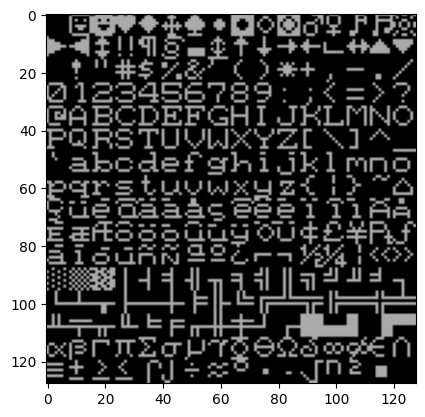

In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

img = Image.open('./charsets/smolserif-8x8.png').convert('F')
plt.imshow(img)

Ah, much better!

Next, let's prepare these images for training. Pix2pix expects 512x256 pixel image with 2 square-shaped images. The input image (A) on the left, the expected output on the right. Thus, we need to upscale our image and also paste it together accordingly.

As we want to teach our model to complete a character set, we put the complete character set on the right side of the training image. On the left side, there's a heavily reduced set where only a few characters are defined.


In [2]:
from font_pairgen import process_all_fonts
process_all_fonts("charsets", "training_pairs", num_variants=5)

Processing boldie-8x8.png
Processing scifi-8x8.png
Processing smolserif-8x8.png


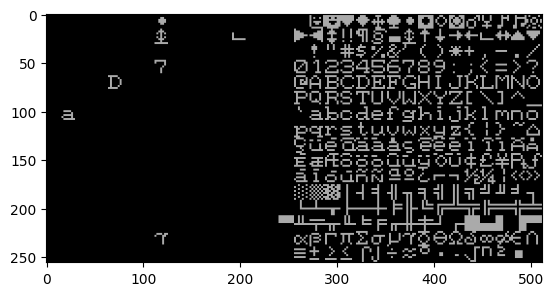

In [3]:
training_img = Image.open('./training_pairs/smolserif-8x8_v0.png').convert('F')
plt.imshow(training_img)

## Building the training dataset

As a next step, we'll train the model


In [6]:
from loader import load_dataset

train_ds = load_dataset("training_pairs", batch_size=8)

for inp, target in train_ds.take(1):
    print(inp.shape, target.shape)
    # Should be: (8, 256, 256, 1), (8, 256, 256, 1)


# Building the U-Net Generator

The [U-Net](https://en.wikipedia.org/wiki/U-Net) Generator is the brain that learns completing half-done character sets.
U-Net is a [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) that was developed for image segmentation.

It takes our reduced font grid (left side, 256×256), and learns to fill in the missing characters.

It's called “U-Net” because of its U-shaped architecture:

- Downsampling path (encoder): captures context (what style, what shapes exist)
- Upsampling path (decoder): reconstructs the image
- Skip connections: copy details from encoder layers to decoder layers (so it doesn't forget fine structure like pixel edges)

Why it's perfect for this case:
The model needs to understand the visual style from the glyphs that are given, and then generate consistent glyphs for the rest.

The U-Net does exactly that — preserve detail where it’s given, and make the rest up with style-aware inference.

In [ ]:
from generator import Generator

gen = Generator()
gen.summary()